# Stock Forecasting w/ LSTM


`-- Leo Lonzarich, 12 January 2022 // [Revised 15-3-23] --`


### Table of Contents
- [Importing Stock Data](#import)
    - [Beta Calculation](#beta)
- [LSTM Model](#lstmmodel)
    - [Preprocessing](#preprocessing)
    - [Building](#build)
    - [Training](#train)
    - [Predictions](#preds)
- [Model Validation](#validation)
    - [Backtesting](#backtest)
    - [Moving Windows](#windows)


### Motivations:
- How accurately can we predict next-day and future equity prices?

- Is it useful to predict prices with multiple metrics, like beta?

- What is the financial risk of investing in a particular equity?

### General Comments:
- Using Long Short Term Memory (LSTM), an artificial recurrent neural network, to predict closing future stock closing performance.
    - LSTM works best when handeling large-scale datasets like these.
<br><br>
- Selecting past 60 days to make next-day predictions.

- This project, and the analysis herein, is meant only to be a supplemental tool alongside general intuition, good sense, analysis of financial climates, etc.

- Credit to ML tutorial of @`Computer Science` on YT.

<br><br>

---
#### TODO

- I'm only using univariate stacked LSTM here. Try Bidirectional LSTM to see if it adds any explanatory power. (https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)

- Make statistical error analysis program to evaluate model efficacy and efficiency (comp time vs. accuracy).

- Eventually incorporate contents into financial package, in combination with general analysis.

- If we choose to include beta, we need to also check market-stock correlations.

- Incorporate sklearn's gridsearchcv to automate finding best model.fit params.

- Consider Gated Recurrent Units (GRUs) for efficiency over LSTMs (https://arxiv.org/pdf/1412.3555v1.pdf_)

- For cross-validation, https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam

from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

# Yahoo API may have broken previous versions of pd_datareader,
# so this is a workaround.
yfin.pdr_override()
pd.options.mode.chained_assignment = None  # default='warn'

## Importing Data<a class="anchor" id="import"></a>
---

We use yfinance here, with a pandas_datareader workaround to address loss of yfinance API. 

For the purposes of this analysis, we will be using adjusted daily closing prices (versus closing price). Since we want to predict future stock performance, closing prices are the natural choice as a predictive metric. Furthermore adjusted price gives stock price after dividend payounts, stock splits, and/or additional share issues, resulting in a more realistic and data-rich representation of share value.

In [131]:
# Yahoo Finance stock scraping.
# **Careful with how many times you run this to avoid IP ban**
TICKER = 'AMZN'
START = dt.datetime(2012, 1, 1)
END = dt.datetime.today()

stock = pdr.get_data_yahoo(TICKER, START, END).rename(columns= {'Adj Close': 'AdjClose'})

print(stock.shape[0], "unique points loaded with attributes: \n", stock.
      keys())

[*********************100%***********************]  1 of 1 completed
2820 unique points loaded with attributes: 
 Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume'], dtype='object')


Verifying that we indeed have the keys listed above, and making sure data is numeric and looks reasonable. (Note that the weekends and bank holidays are not included $\sim$ 255 days each year.)

The descriptive statistics are included below to further confirm are what we might expect.

Lastly, we run a check to locate any NaNs in the data. We return False when none are found.

In [132]:
stock.tail()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2023-03-13,89.970001,94.019997,88.120003,92.430000,92.430000,72397100
2023-03-14,93.830002,95.070000,92.709999,94.879997,94.879997,60912700
2023-03-15,93.220001,96.669998,93.070000,96.199997,96.199997,70731800
2023-03-16,95.750000,100.989998,95.610001,100.040001,100.040001,84446900
2023-03-17,99.790001,100.660004,97.459999,98.949997,98.949997,87173200


In [133]:
# Use applymap to reduce tabular clutter.
stock.describe().applymap(lambda x: f"{x:0.3f}")

,Open,High,Low,Close,AdjClose,Volume
count,2820.000,2820.000,2820.000,2820.000,2820.000,2820.000
mean,68.656,69.449,67.777,68.627,68.627,80419267.801
std,53.606,54.263,52.873,53.555,53.555,42726758.200
min,8.691,8.913,8.600,8.797,8.797,17626000.000
25%,18.028,18.287,17.881,18.101,18.101,53826175.000
50%,49.293,49.585,48.805,49.141,49.141,69058000.000
75%,98.588,99.928,97.450,98.817,98.817,92951500.000
max,187.200,188.654,184.839,186.570,186.570,477122000.000


In [134]:
stock.isnull().values.any()

False

To really see what we are working with, let's plot the adjusted closing price below over the time frame we specified.

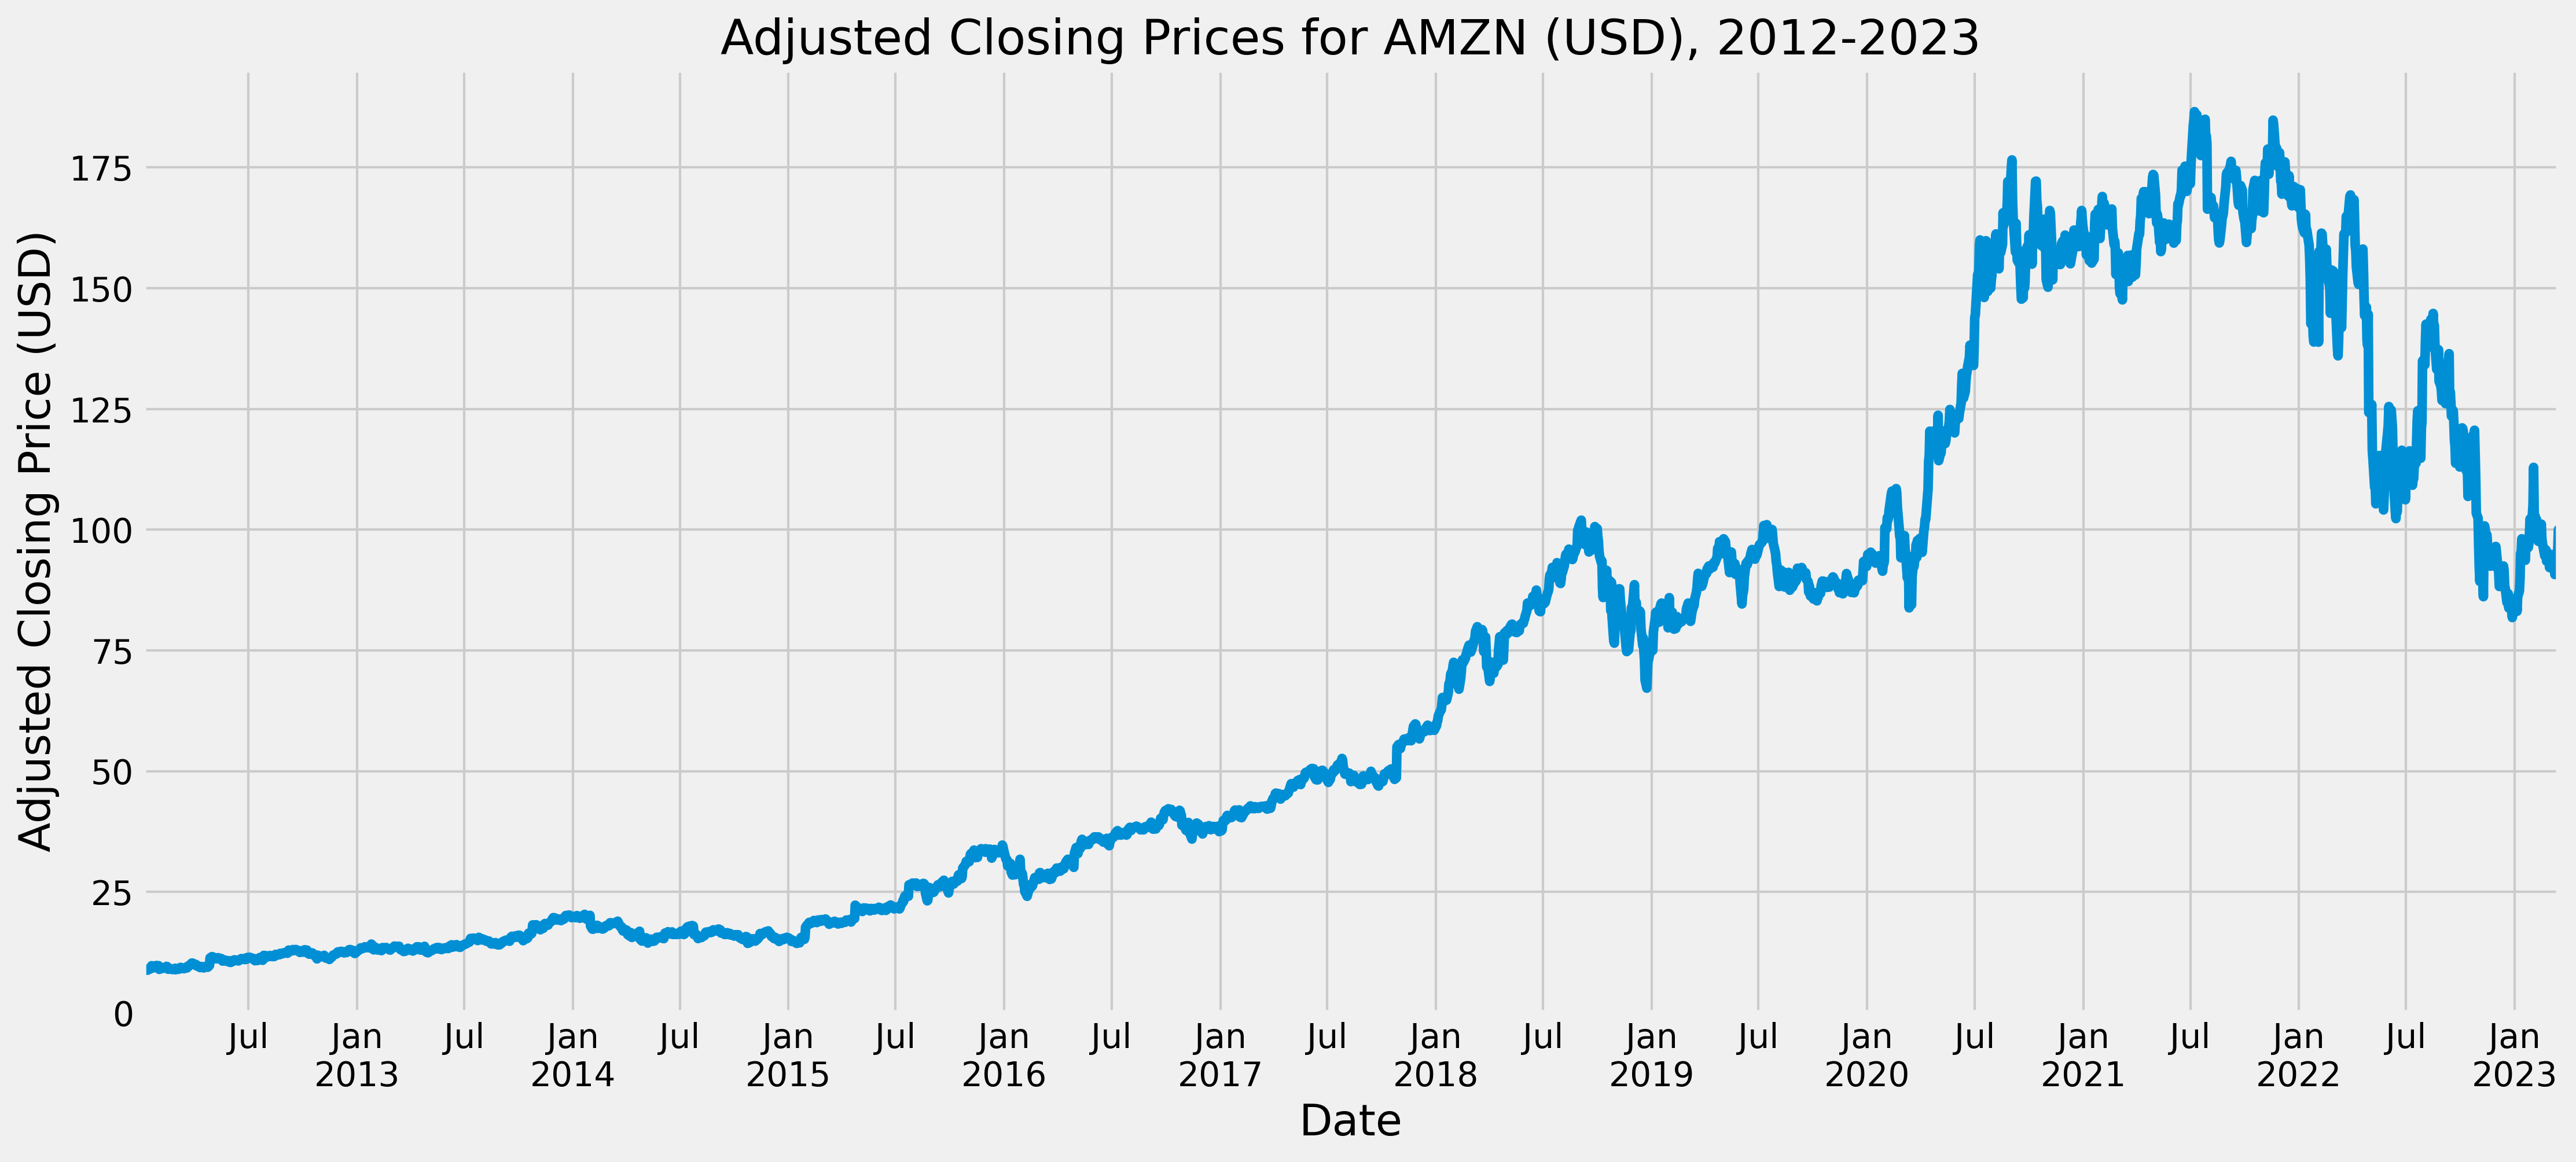

In [135]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose)

ax.set_title('Adjusted Closing Prices for %s (USD), %s-%s' 
             %(TICKER, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

plt.show()

### Beta Calculation:<a class="anchor" id="beta"></a>

One of the questions we seek to answer here is to what degree multivariate LSTM is enhanced over univariate LSTM. That is, do we enhance predictive power by including metrics like beta, volume, CAPE, PE?

To this end, for each day in our `stock` dataframe, we calculate beta with the previous year of adjusted closing prices and append them to the dataframe using a roll generator from linalg to improve efficiency. Following this method, the first year's worth of stock data should not include any betas. 

Ideally, beta should be calculated with a market that is highly correlated with the target stock. For the case of most tech stocks, the SPY index should work handily.

(Recall above that there are $\sim$ 255 market days per year.)


In [136]:
# Specify number of days to use for beta calculation (255 = 1yr).
window = 252 

# Specify a market highly correlated with 'stock'.
market_ticker = 'SPY'

def beta(df, market=None):
    # If the market values are not passed,
    # I'll assume they are located in a column
    # named 'Market'.  If not, this will fail.
    if market is None:
        market = df['MarketClose']
        df = df.drop('MarketClose', axis=1)
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values)
    return float(b[1])

def roll(df, w=252):
    # Takes 'w'-sized slices from dataframe, incrementing 1 entry at a time.
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w],
                           df.columns)


#### Combining stock + market data and computing.
market = pdr.get_data_yahoo(market_ticker,
                            START,
                            END).rename(columns={'Adj Close': 'MarketClose'})

betas = np.array([])
data = pd.concat([stock.AdjClose, market.MarketClose], axis=1)

for  i, sdf in enumerate(roll(data.pct_change().dropna(), window)):
    betas = np.append(betas, beta(sdf))

data_added = data.drop(index=data.index[:window], axis=0, inplace=False)
data_added['Beta'] = betas.tolist()

[*********************100%***********************]  1 of 1 completed


Let's plot the stock and correlated market side by side, and include the rolling beta calculation for reference.

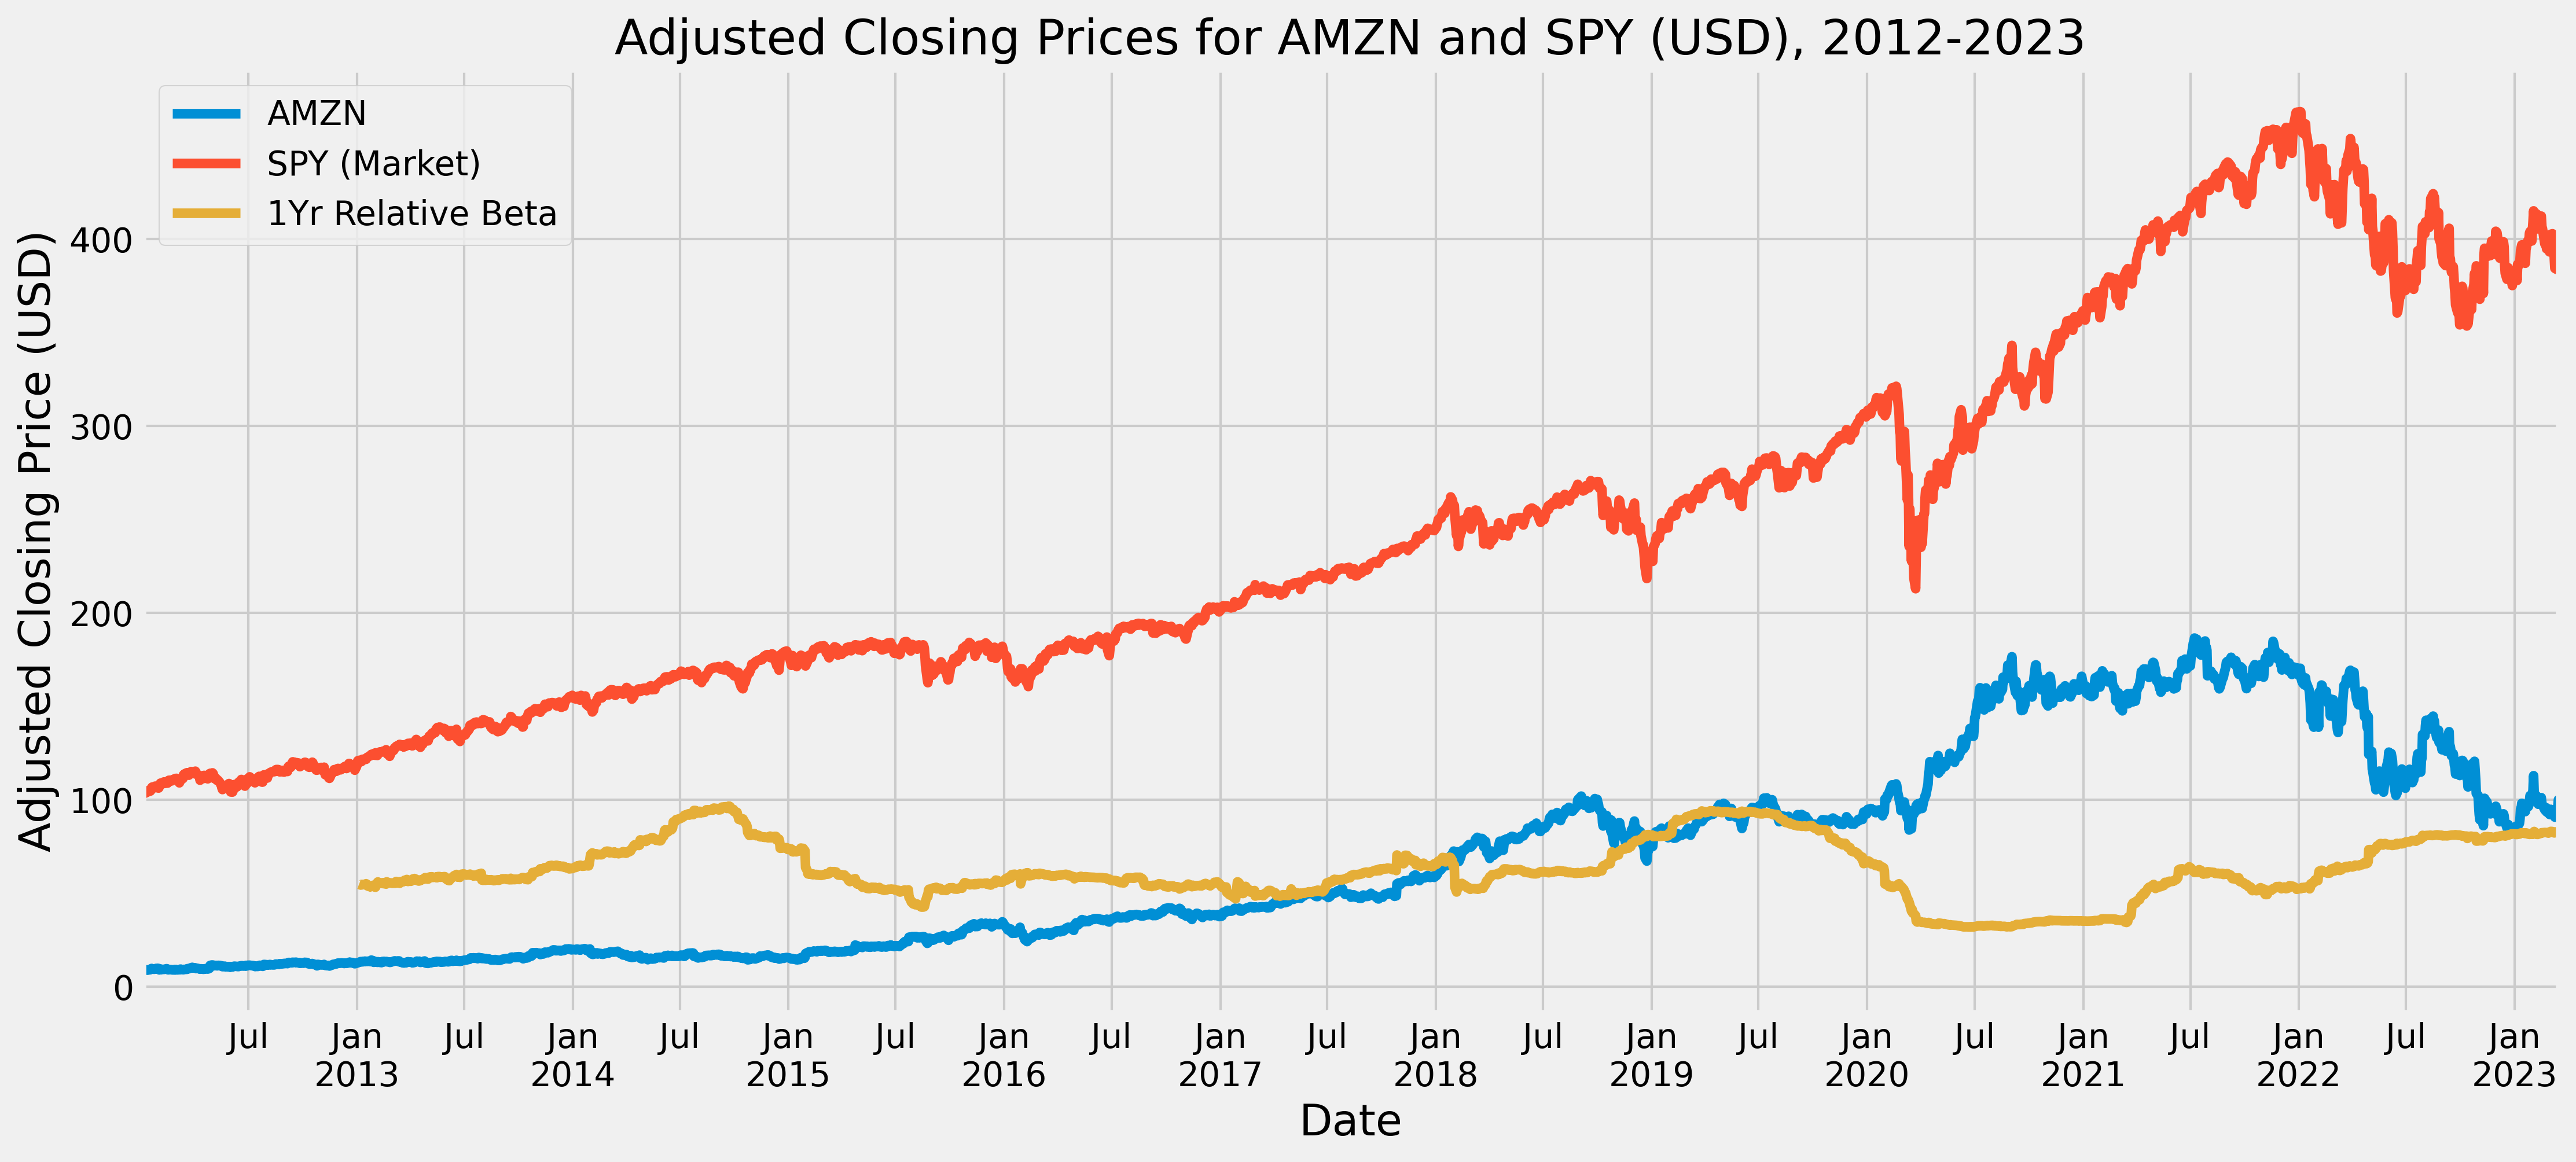

In [138]:
# Plotting opening prices.

fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(stock.index, stock.AdjClose, label=TICKER)
ax.plot(market.index, market.MarketClose, label=market_ticker + ' (Market)')
ax.plot(data_added.index, data_added.Beta*50, linestyle='-', label='1Yr Relative Beta')


ax.set_title('Adjusted Closing Prices for %s and %s (USD), %s-%s' 
             %(TICKER, market_ticker, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend()

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(stock.index.min(), stock.index.max());

plt.show()

## LSTM Model<a class="anchor" id="lstmmodel"></a>
---

We will use long short-term memory (LSTM) networks, a recurent neural network (Deep Learning). LSTM is especially useful here because it can learn long-term dependencies in time-series data and is surprisingly scalable and robust. See this article https://colah.github.io/posts/2015-08-Understanding-LSTMs/ for a more detailed explanation of all the benefits this type of network offers.

We will first evaluate and univariate LSTM here, and then incorporate beta to assess the effectiveness of additional parameters in a separate section.

### Preprocessing:<a class="anchor" id="preprocessing"></a>

Building any good DL network starts with preprocessing. We will separate out the adjusted close prices, scale down numerical values to just around the origin (large numbers can lead to instabilities or otherwise slower gradient descent convergence), and make our train-test splits.

*** For the purposes of building/improving this package, we will start 2 years back from the end date in our stock data and predict the next day price from that date forward. Each next day prediction is set to use the previous 60 days of adjusted closing prices. Therefore, we should end up with approximately 75% of our predictions having been made solely using the model's own predictions. Though this appears sketchy on its face, predictions do not appear to falter once this takes place. (See the plot at the end of this modeling section.)

#### Converting Time Series to a Supervised Learning Problem:<a class="anchor" id="timeseriesconvert"></a>

For univariate time series where we are interested in next-step predictions, the lag observations (those that occur at prior timesteps) are used as inputs to give an output observation for the current timestep. In effect, observations (t1, t2, t3) are used to predict the observation at time t4. One can then step forward and use (t2, t3, t4) to predict t5, and so on, thereby we recast the time series as a supervised learning problem. 

For a ML model, $f$, to forecast like this it requires splitting our data into input and output features X and y, respectively, so that we can have $y=f(X)$. For example, noting the above, we could have X = (t1, t2, t3) and y = t4. Transforming from time series to supervised learning is not so trivial, but it can be achieved very quickly with `Keras.preprocessing.sequence.TimeseriesGenerator`. Unfortunately, `.preprocessing` is depreciated, so we will include another function below that performs similarly and leave `generator` commented.

(See https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/ for more.)


In [139]:
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [178]:
def data_split(data, lag=60, days=1, train_ratio=0.70,
               validation=False, backtest=False):
    """
    Prepping stock data for neural net; scaling down 
    values and making train-test split.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    # Selecting 'AdjClose' prices as input and target feature for time series.
    data_adj = data.filter(['AdjClose']).values

    # Scaling data. Ensures quicker convergence to solution.
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data_adj)

    # Splitting input features and target object, X and y.
    supervised_data = series_to_supervised(scaled_data, n_in=lag, n_out=days)
    X = supervised_data.loc[:, supervised_data.columns != 'var1(t)'] 
    y = supervised_data['var1(t)'] # Isolating target object.

    # Selecting converted data for train-test split.
    len_training = int(np.ceil(len(scaled_data) * train_ratio))

    X_train = X.iloc[0:len_training].to_numpy()
    y_train = y.iloc[0:len_training].to_numpy()
    # X_train, y_train = np.array(X_train), np.array(y_train)

    # Making validation/test split.
    if validation:
        len_valid = int((len(X) - len_training)/2)
        len_valid += len_training-60

        # We subtract lag days since they are needed to actually  
        X_valid = X.iloc[len_training-60:len_valid].to_numpy()
        y_valid = data_adj[len_training:len_valid]

        X_test = X.iloc[len_valid-60:].to_numpy()
        y_test = data_adj[len_valid:]

    else:
        X_test = X.iloc[len_training-60:].to_numpy()
        y_test = data_adj[len_training:]

    # Reshaping to obtain 3D reps (currently 2d) to pass into LSTM.
    # LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.
    X_train = np.reshape(X_train, (X_train.shape[0],
                                   X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0],
                                 X_test.shape[1], 1))

    if len(X_test) != len(y_test):
        raise Warning('X, y length mismatch.')
    
    if validation:
        X_valid = np.reshape(X_valid, (X_valid.shape[0],
                                       X_valid.shape[1], 1))
        return X_train, y_train, X_valid, y_valid, X_test, y_test, scaler
    
    elif backtest:
        return X, y, scaler

    elif not backtest and not validation:
        return X_train, y_train, X_test, y_test, scaler
    
    else:
        ValueError(
            "Cannot simultaneously perform 'backtest' and 'validation'."
            )
        exit()


# generator = TimeseriesGenerator(scaled_data, scaled_data, length=60, batch_size=1)

In [179]:
LAG = 60 # Number of days to use for predicting the following day(s).
DAYS = 1 # Number of days to predict with each lag period.
TRAIN_RATIO = 0.70

X_train, y_train, X_test, y_test, scaler = data_split(stock, lag=LAG, 
                                                      days=DAYS, train_ratio=TRAIN_RATIO)

### Building and Hyperparameter Tuning:<a class="anchor" id="build"></a>

The effectivenes of our model depends on a number of different parameters such the number of LSTM and Dense layers. To improve model accuracy, we build an objective function and use `Optuna` to locate optimized parameter combinations.

(See https://medium.com/geekculture/10-hyperparameters-to-keep-an-eye-on-for-your-lstm-model-and-other-tips-f0ff5b63fcd4 for param tuning.)

In [251]:
def create_model(*args):
    # We add some qualifiers so that create model can be used in Optuna
    # optimization as well as for single model generation.
    if str(args[0]) == 'trial':
        trial=trial
        in_shape=args[1]

        if args[1] != int:
            raise ValueError("Argument is not int; should be the the number \
                             of features in your training data.")
    
    if args[0] == int(args[0]) and len(args) == 1:
        in_shape = args[0]

    if len(args) > 2:
        raise OverflowError("Too many arguments to unpack. Enter 'trial, \
                            in_shape', or 'in_shape.")
        exit(1)
    
    model = Sequential()
    model.add(
        LSTM(
            units=128,
            activation='tanh',
            recurrent_activation='sigmoid',
            unroll=False,
            use_bias=True,
            # dropout=dropout,
            # recurrent_dropout=recurrent_dropout,
            return_sequences=True,
            input_shape=(in_shape, 1)
        )
    )
    model.add(
        LSTM(
            units=64,
            activation='tanh',
            recurrent_activation='sigmoid',
            unroll=False,
            use_bias=True,
            # dropout=dropout,
            # recurrent_dropout=recurrent_dropout,
            return_sequences=False,
        )
    )
    model.add(
        Dense(
            25,
            activation=None,
            # use_bias=True
        )
    )
    model.add(
        Dense(
            1,
            # activation='relu',
            use_bias=True
        )
    )

    # Only use 'accuracy' metric for classification.
    model.compile(
        loss='mean_squared_error',
        optimizer='adam',
        metrics=['mean_squared_error'] # ['mean_absolute_percentage_error']
    )
    
    return model

### Training Model: <a class="anchor" id="train"></a>

There are three metrics we can use to measure LSTM model error: mean squared error (MSE), root MSE (RMSE), and mean absolute percentage error (MAPE). MAPE will give us a rough percentage error, while RMSE will give us an error in units of the features (in this case, USD). 

RMSE we will use most often for its interpretability. However, we will use MSE when running the hyperparameter optimizer because MSE is much more suceptible to outliers -- meaning more sensitive during training -- and, therefore, can allow greater accuracy in hyperparameter tuning.

In [252]:
model = create_model(X_train.shape[1])
model.fit(X_train, y_train, batch_size=2, epochs=1, verbose=True)

2023-03-21 11:41:43.531107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-21 11:41:43.799751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-21 11:41:43.965936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-21 11:41:44.234384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-21 11:41:44.619577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


987/987 [==============================] - 36s 33ms/step - loss: 5.2742e-04 - mean_squared_error: 5.2742e-04


### Predictions: <a class="anchor" id="preds"></a>

We need a point of comparison for future models, and so use root mean squared error to quantify model performance.

In [133]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 60, 128)           66560     
                                                                 
 lstm_37 (LSTM)              (None, 64)                49408     
                                                                 
 dense_36 (Dense)            (None, 25)                1625      
                                                                 
 dense_37 (Dense)            (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [182]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# RMSE.
rmse = np.sqrt(np.mean(predictions - y_test)**2)

print("Model RMSE: %.4f" %rmse)

2023-03-19 22:23:56.035502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-19 22:23:56.123487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/27 [>.............................] - ETA: 16s

2023-03-19 22:23:56.301001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 1s 28ms/step
Model RMSE: 6.9352


We roughly visualize the results of our model in the plot below, where we include the actually adjusted close price history in blue (training) and red (validation), and the predictions overlayed in orange.

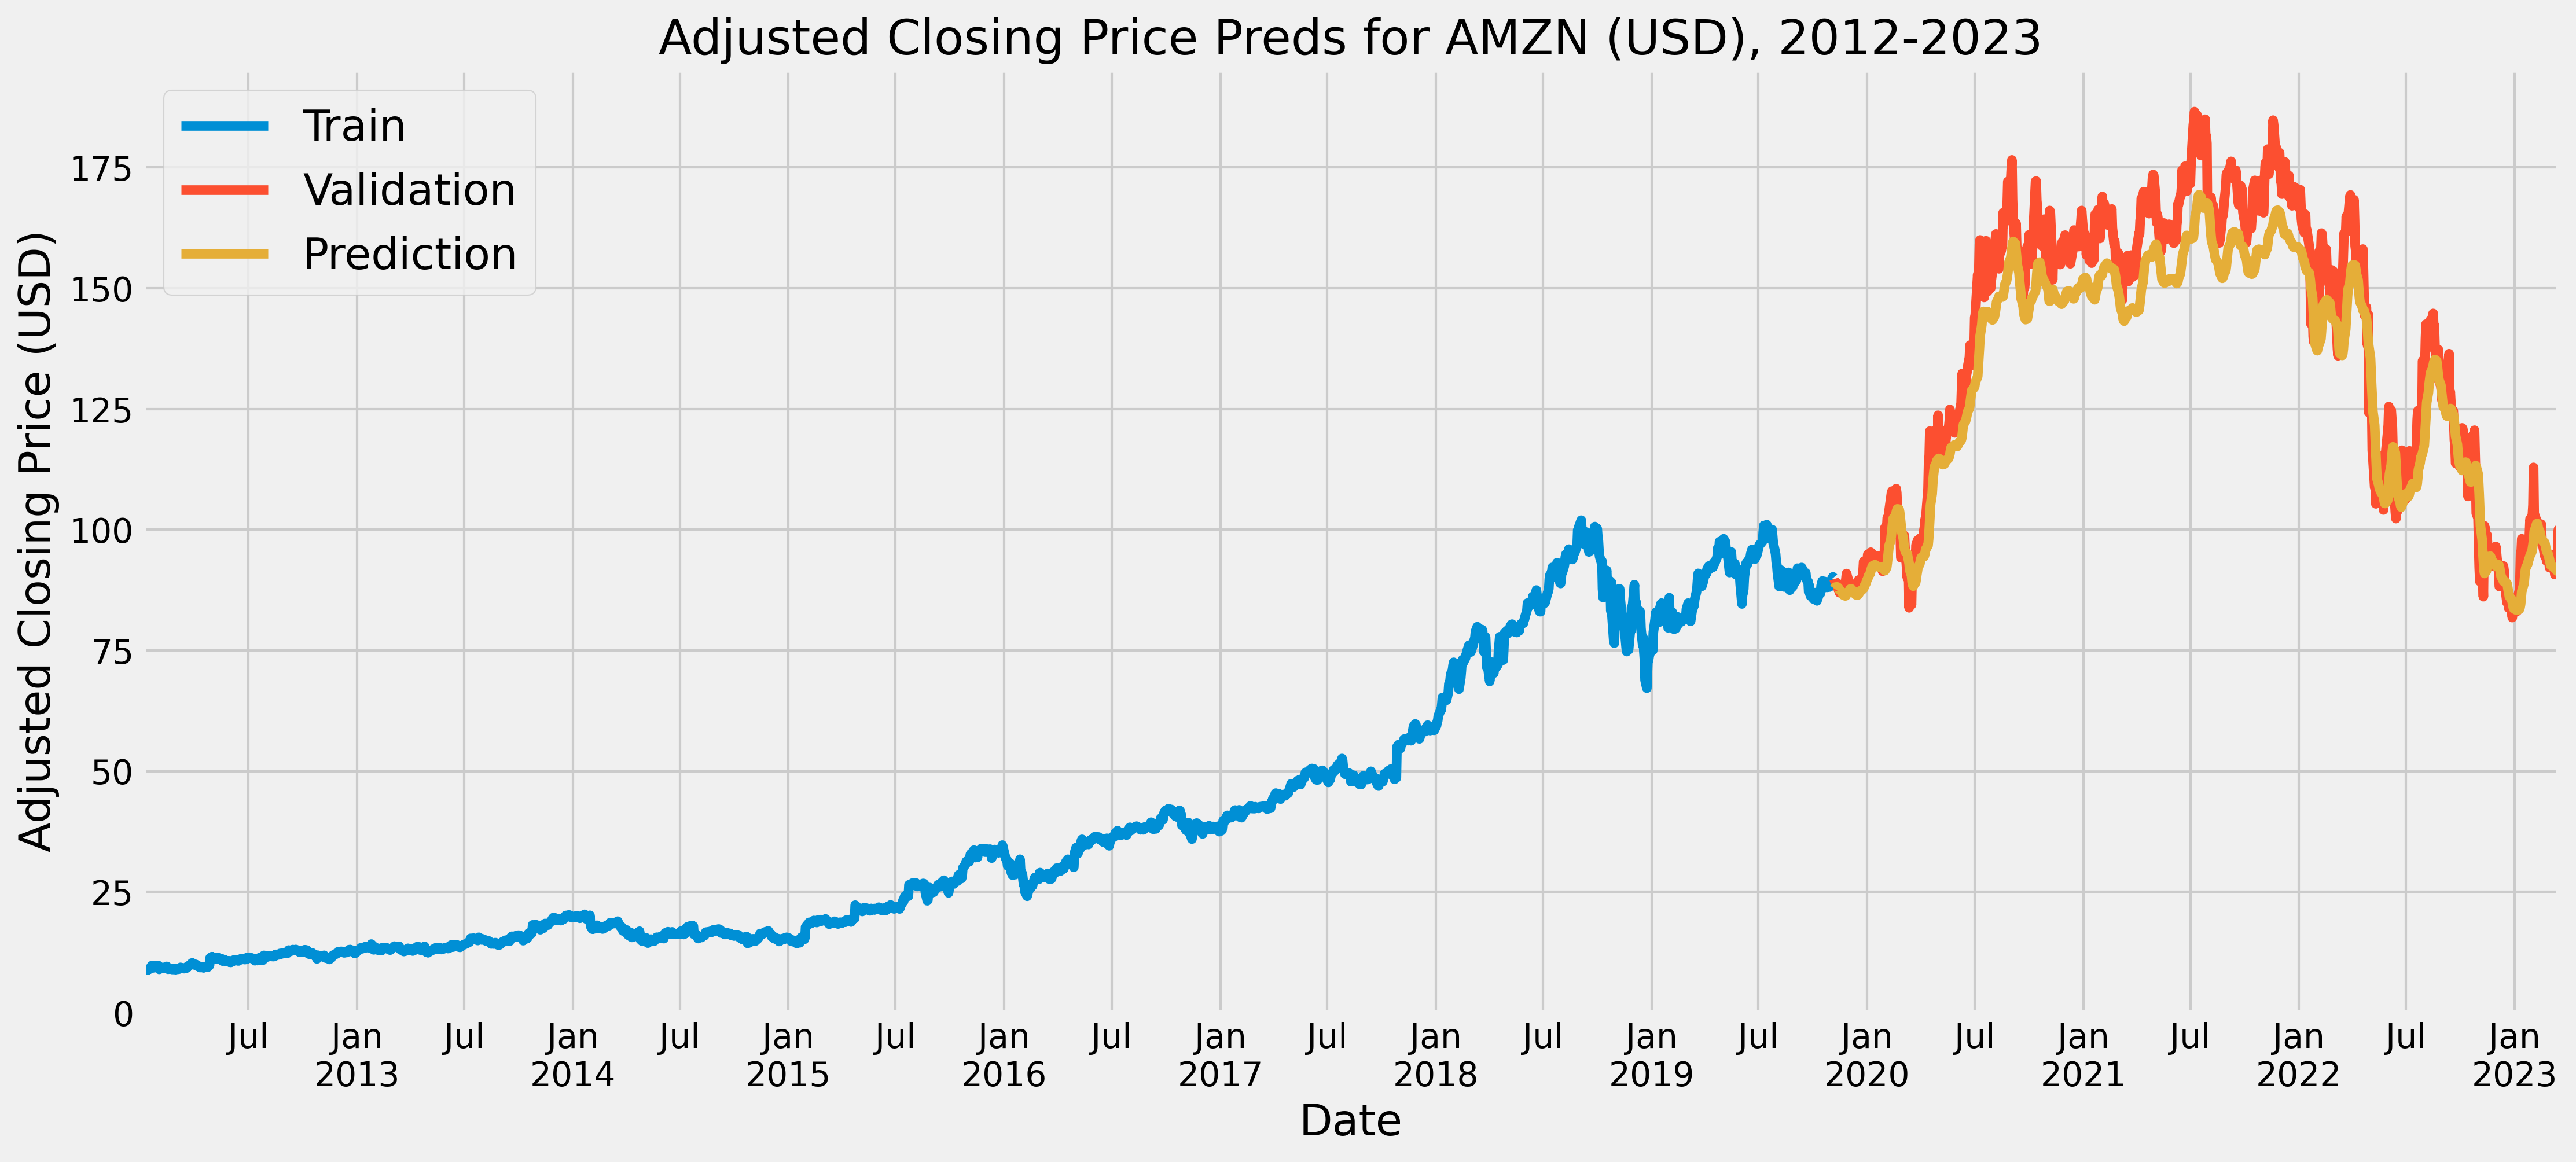

In [183]:
# plotting results.
data = data.filter(['AdjClose'])

train = data[:len(X_train)]
valid = data[len(X_train):] # actual data that model predicted.
valid['Predictions'] = predictions


fig, ax = plt.subplots(1,1, dpi=300, figsize=(16,8),
    constrained_layout=False)

ax.plot(train.index, train.AdjClose, label='Train')
ax.plot(valid.index, valid.AdjClose, label='Validation')
ax.plot(valid.index, valid.Predictions, label='Prediction')


ax.set_title('Adjusted Closing Price Preds for %s (USD), %s-%s' 
             %(TICKER, START.year, END.year))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Adjusted Closing Price (USD)', fontsize=18)
ax.legend(fontsize='18')

# Set major and minor date tick locators
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,6))
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, 
                                      show_offset=False)
ax.xaxis.set_major_formatter(maj_fmt)

ax.figure.autofmt_xdate(rotation=0, ha='center')
ax.set_xlim(data.index.min(), data.index.max());

plt.show()

## Model Validation <a class="anchor" id="validation"></a>

---

### Backtesting: <a class="anchor" id="backtest"></a>

How do we know to place trust in our model? Typically we would do this with k-fold cross-validation, but such a technique requires assuming all observations are independent. 

Financial time series data is interdepenedent (neither independently nor identically distributed because of serial correlation and time-varying standard deviation; heteroskedasticity), however, and so we resort to walk-forward (cross) validation, which preserves temporal order.

To do this, we select a base window of observations to training the model on (starting from the first observation) and expand the window forward in time by one observation for every fold of the validation. (See diagram below.)

We perform the modeling process again with backtesting below.


![Walk-forward validation](walk-forward.png "Walk-forward Backtest Validation")

We also consider sliding window cross-validation here, which would have us keep a fixed window size and step forward, dropping older data. The benefit to using this blocked backtesting is that it may be reasonable to assume that the data from several years ago is not entirely representative of the current stock/market and, therefore, that it is not wise to use such data in making future observations.

However, since we are only looking at the last ~10 years of stock histories, the benefit of sliding windows may be limited.

![Sliding-window validation](sliding-window.png "Sliding-window Backtest Validation")

(Photo credit: https://www.uber.com/blog/omphalos/)

In [143]:
class SlidingSeriesSplit():
    """
    parameters
    ----------
    n_test_folds: int
        number of folds to be used as testing at each iteration.
        by default, 1.
    """
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        if self.n_splits > n_samples:
            raise ValueError(
                "Cannot have number of folds =%i greater"
                " than the number of samples: %i." %(self.n_splits, n_samples))

        margin = 0
        for i in range(self.n_splits):
            # Sets the overlap of each block.
            start = i * int(k_fold_size/3)
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [205]:
def plot_cv_indices(cv, X, y, ax, n_splits, linewidth=10):
    """
    Plotting folds for walk forward-validation.
    """
    # Generate the training/testing visualizations for each CV split.
    for i, (train, test) in enumerate(cv.split(X=X, y=y, groups=None)):
        # Fill in indices with the training/test groups.
        indices = np.array([np.nan]*len(X))
        indices[train] = 1
        indices[test] = 0

        ax.scatter(
            range(len(indices)),
            [i+1] * len(indices),
            c=indices, marker='_',
            cmap='coolwarm',
            linewidth=linewidth,
            vmin=-.2, vmax=1.2
            )

    # Formatting
    ax.set(
        yticks=np.arange(1,n_splits+1),
        xlabel="Historical Days Included",
        ylabel="CV Iteration",
        ylim=[n_splits+1.2, -.1]
        )
    ax.set_title("Walk-forward Splits for %i CV Iterations"
                 %n_splits, fontsize=15)
    ax.legend([Patch(color='tomato'), Patch(color='royalblue')],
          ['Train', 'Test'])
    
    return ax

We make and visualize the train-test splits for each CV pass below, in addition to displaying the number of samples for training and testing in each.

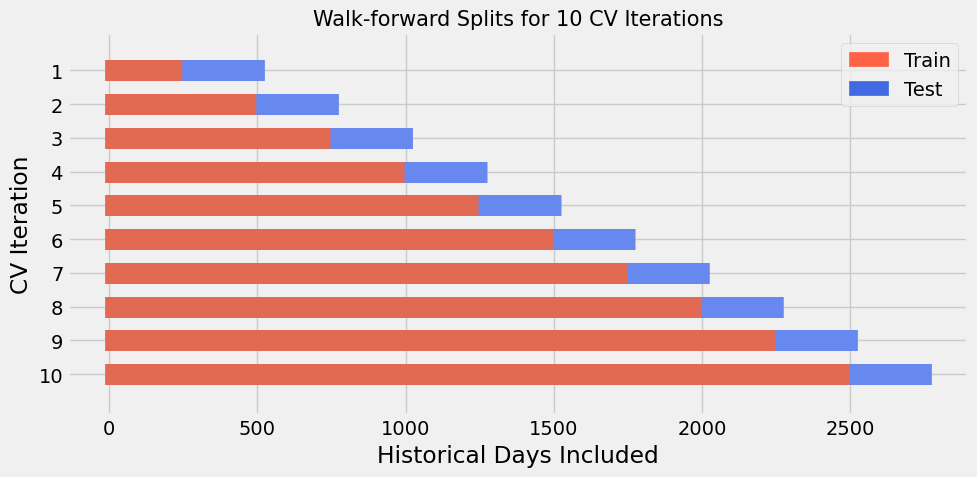

In [207]:
LAG = 60
DAYS = 1 
TRAIN_RATIO = 0.70
N_SPLITS = 10
STYPE = TimeSeriesSplit # SlidingSeriesSplit


data_adj = stock.filter(['AdjClose']).values

# Scaling data. Ensures quicker convergence to solution.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_adj)

# Splitting input features and target object, X and y.
supervised_data = series_to_supervised(scaled_data, n_in=LAG, 
                                       n_out=DAYS)
y = supervised_data['var1(t)'] # Isolating target object.
X = supervised_data.loc[:, supervised_data.columns != 'var1(t)'] 


series_split = STYPE(n_splits=N_SPLITS)
fig, ax = plt.subplots(figsize=(10, 5))
plot_cv_indices(series_split, X, y, ax, N_SPLITS, 15)

plt.tight_layout()
plt.show()

In [208]:
'Training, Testing', [(el[0].shape, el[1].shape) 
                      for el in series_split.split(X)]

('Training, Testing',
 [((260,), (250,)),
  ((510,), (250,)),
  ((760,), (250,)),
  ((1010,), (250,)),
  ((1260,), (250,)),
  ((1510,), (250,)),
  ((1760,), (250,)),
  ((2010,), (250,)),
  ((2260,), (250,)),
  ((2510,), (250,))])

### Running Moving Window Validation: <a class="anchor" id="windows"></a>

We start by making a rolling or expanding window split with `TimeSeriesSplit` or `SlidingSeriesSplit`, respectively, and read out the indicies used in each fold below.

Following this, we train seperate models on each fold and take the mean on the RMSEs for each. This is returned and interpreted as an aggregate error.

In [253]:
def backtest_split(data, lag=60, days=1, train_ratio=0.70,
                   n_splits=5, method=TimeSeriesSplit, verbose=False):
    """
    Splitting data for backtesting using either rolling or
    expanding window.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    series_split = method(n_splits=n_splits)

    # Separating input and target features in data.
    X, y, scaler = data_split(data, lag=lag, days=days, 
                              train_ratio=train_ratio, backtest=True)

    X = np.asarray(X) # series_split requires np arrays.
    y = np.asarray(y)

    if verbose:
        for fold, (train_index, test_index) in enumerate(series_split.split(X, y)):
            print("Fold: {}".format(fold))
            print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
            print("\n")
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
    return X, y, series_split, scaler


def backtest_validation(data, make_model, trial=None, lag=60, days=1, train_ratio=0.7,
                        n_splits=5, batch_size=1, epochs=1,
                        method=TimeSeriesSplit, verbose=False): 
    """
    Performing rolling or expanding window backtest
    validation for time series data that cannot be
    subjected to the typical procedure of cross validation.
    data: DataFrame, all stock data.
    lag: int, number of days used for prediction.
    days: int, number of days to predict.
    train_ratio: float, percentage of data for training.
    validation: bool, split data into train/valid/test when True.
    backtest: bool, only performs x-y split when True.
    Returns
        X_train: array, independent training features.
        y_train: array, objective training feature.
        X_test: array, independent test features.
        y_test: array, objective test feature.
        X_valid: array, independent validation features.
        y_valid: array, objective validation feature.
        X: array, independent features.
        y: array, target feature.
    """
    # Fetching feature split and backtest method.
    prams = backtest_split(data, lag=lag, days=days,
                           train_ratio=train_ratio, n_splits=n_splits,
                           method=method, verbose=False)
    
    X, y = prams[0], prams[1]
    series_split, scaler = prams[2], prams[3]
    
    agg_rmse = np.zeros(n_splits) # Initializing; collects all model RMSEs.

    for i, (train_index, test_index) in enumerate(series_split.split(X, y)):
        if verbose:
            print("[Start fold %i/%i]" %(i+1, n_splits))

        # Collect train and test data for the fold.
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build new model for the fold.
        model = None
        in_shape = X_train.shape[1]
        
        if trial==None:
            model = make_model(in_shape)
        else:
            # We pass a trial object for Optuna hyperpram optimization.
            model = make_model(trial, in_shape)

        model.fit(
            X_train,
            y_train,
            validation_data=(X_test, y_test),
            shuffle=True,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
        )

        # Calculate the fold's RMSE.
        y_preds = model.predict(X_test)
        y_preds = scaler.inverse_transform(y_preds)
        rmse = mean_squared_error(y_test, y_preds, squared=False)

        if verbose:
            print("Loss for fold %i: %.3e" %(i+1, rmse))

        agg_rmse[i] = rmse

    return agg_rmse

In [ ]:
BATCHSIZE = 1
EPOCHS = 1
N_SPLITS = 5

agg_rmse = backtest_validation(stock, make_model=create_model,
                               n_splits=2, batch_size=2, method=SlidingSeriesSplit,
                               verbose=True)

print(agg_rmse)
print("Average Loss: %.3e (+/- %.3e)" %(agg_rmse.mean(),
                                           agg_rmse.std()))

In [ ]:
print('Finding study best parameters')
best_lr = float(study.best_params['learning_rate'])
best_weight_decay = float(study.best_params['weight_decay'])
best_epoch = int(study.best_params['num_train_epochs'])


print('Extract best study params')
print(f'The best learning rate is: {best_lr}')
print(f'The best weight decay is: {best_weight_decay}')
print(f'The best epoch is : {best_epoch}')

print('Create dictionary of the best hyperparameters')
best_hp_dict = {
    'best_learning_rate' : best_lr,
    'best_weight_decay': best_weight_decay,
    'best_epoch': best_epoch
}


In [ ]:
print('Saving the best Optuna tuned model:')
if not path.exists('model'):
    os.mkdir('model')

model_path = "model/{}".format(NAME_OF_MODEL)
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
with open("{}.pickle".format(study.best_trial.number), "rb") as fin:
    best_clf = pickle.load(fin)

### Multivariate LSTM Test:

See https://machinelearningmastery.com/use-features-lstm-networks-time-series-forecasting/

In [114]:
# consolidating 'Close' prices to one stock.

# data = datFull.filter(['AdjClose', 'beta']).values
# len_training = math.ceil(len(data) * 0.8)

# # scaling data. Ensures quicker convergence to solution.
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(data)

# # scaled training data.
# train_data = scaled_data[0:len_training,:]

# x_train = [] # features
# y_train = [] # desired prediction

# for i in range(60, len(train_data)):
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])
    
# x_train, y_train = np.array(x_train), np.array(y_train)

# # reshaping to obtain 3D reps for x_train (which is currently 2d) to pass into LSTM.
# # LSTM expects d1 # of samples, d2 # of timesteps, and d3 # of features.

# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))




# # using 2 LSTM layers + Dense 25 neuron + Dense 1 neuron.
# model = Sequential()

# model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model.add(LSTM(50, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error') # use categorical crossentropy for categories.




# model.fit(x_train, y_train, batch_size=1, epochs=1)



# # Creating test data w/ scaled values.
# test_data = scaled_close[len_training - 60:, :]

# x_test = []
# y_test = close[len_training:, :]
# for i in range(60, len(test_data)):
#     x_test.append(test_data[i-60:i, 0])
    
# x_test = np.array(x_test)

# # reshaping 2d x_test into 3d.
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




# predictions = model.predict(x_test)
# predictions = scaler.inverse_transform(predictions)

# # computing error.
# rmse = np.sqrt(np.mean(predictions - y_test)**2)

# print("Model error: %.4f" %rmse)







---

In [1]:
import math
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import datetime

import requests_cache

In [2]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = 'DEFAULT_HEADERS'

/var/folders/5l/9brv6cdn1b97f82knqyjcb4m0000gn/T/ipykernel_13015/389028320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


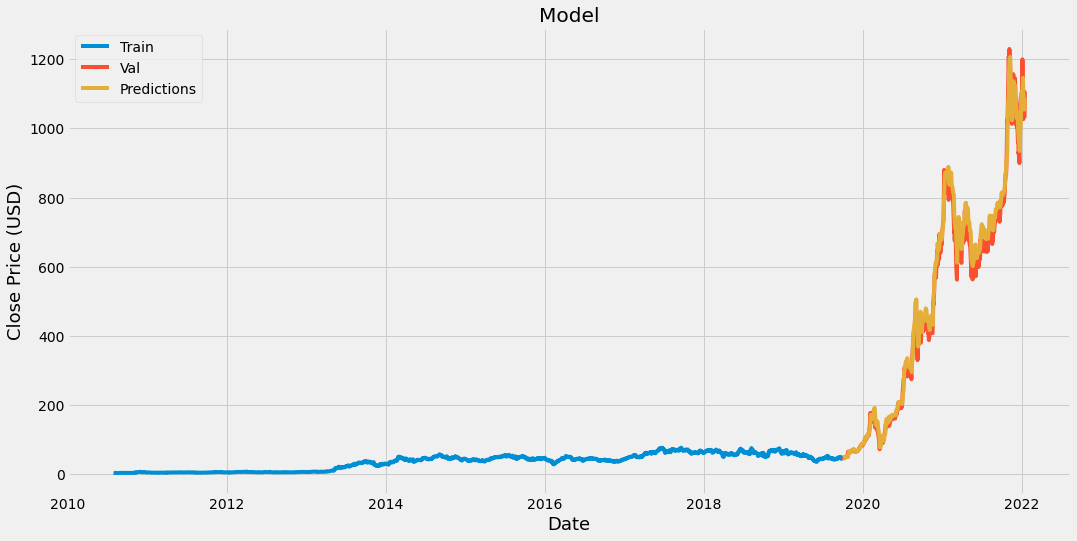

In [15]:
# plotting results.
data = df.filter(['Close'])

train = data[:len_training]
valid = data[len_training:] # actual data that model predicted.
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (USD)', fontsize=18)

plt.legend(['Train', 'Val', 'Predictions'])

plt.show()